# Introduction to Computer Vision Part 1

Importing packages:

In [177]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

Loading MNIST dataset:

In [178]:
dataset = MNIST(root='data/', download = True)

Visualize some images from our MNIST dataset:

Label: 5


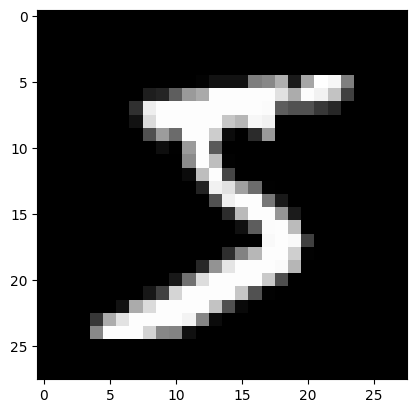

In [179]:
image, label = dataset[0]
plt.imshow(image, cmap = 'gray')
print('Label:', label)

Label: 8


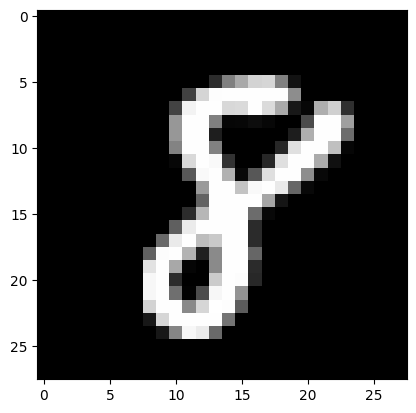

In [180]:
image, label = dataset[761]
plt.imshow(image, cmap = 'gray')
print("Label:", label)

Each record in the MNIST dataset consists of 2 parts:
<li> An <b> image </b> of a handwritten number.
<li> A <b> label </b> indicating the correct number appears in the image.

## PyTorch Basics

### Tensors

Tensors are a specialized data strcuture that are similar to arrays and matrices. In PyTorch, we use tensores to encode inputs and outputs of a model, as well as the model's parameters.



In [181]:
t1 = torch.tensor(4.)
print(t1.ndim)
print(t1.shape)
print(t1.item())

0
torch.Size([])
4.0


In [182]:
# Vector
vector = torch.tensor([1,3,5])

# Matrix
matrix = [[5.,6], [7,8], [9,10]]
t3 = torch.tensor(matrix)

In [183]:
# Tensor
tensor = torch.rand(3, 2, 3)

# Find out details about the tensor
print(tensor)
print(f'Shape of tensor: {tensor.shape}')
print(f'Datatype of tensor: {tensor.dtype}')
print(f'Device tensor is stored on: {tensor.device}')

tensor([[[0.3396, 0.5474, 0.8767],
         [0.3283, 0.6763, 0.1765]],

        [[0.1106, 0.8225, 0.9118],
         [0.4973, 0.1435, 0.2307]],

        [[0.9637, 0.3136, 0.7800],
         [0.9159, 0.1830, 0.7791]]])
Shape of tensor: torch.Size([3, 2, 3])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


<b> Tensors operations and functions </b>

Basic operations include:
<li> Addition
<li> Subtraction
<li> Multiplication(element-wise)
<li> Division
<li> Matrix multiplication

In [184]:
t = torch.tensor([1,2,3,5])
print("Add 10: ", t + 10)
print("Subtract tensor([1, 2, 3, 4]):", torch.sub(t, torch.tensor([1,2,3,4])))
print("Element-wise multiplication: ", t * t)
print("Matrix multiplication:", torch.matmul(t,t))

Add 10:  tensor([11, 12, 13, 15])
Subtract tensor([1, 2, 3, 4]): tensor([0, 0, 0, 1])
Element-wise multiplication:  tensor([ 1,  4,  9, 25])
Matrix multiplication: tensor(39)


<b> Gradient </b>

In [185]:
x = torch.tensor(1., requires_grad= True)
w = torch.tensor(2., requires_grad= True)
b = torch.tensor(3., requires_grad= True)
y = w * x + b
y.backward()
print("dy/dx:", x.grad)
print("dy/dw:", w.grad)
print("dy/db:", b.grad)


dy/dx: tensor(2.)
dy/dw: tensor(1.)
dy/db: tensor(1.)


<b> Intreroperability with Numpy </b>

In [186]:
array = np.arange(1.0, 8.0)
tensor = torch.from_numpy(array)
array, tensor

(array([1., 2., 3., 4., 5., 6., 7.]),
 tensor([1., 2., 3., 4., 5., 6., 7.], dtype=torch.float64))

<b> Running tensors on GPU </b>

In [187]:
torch.cuda.is_available()

True

In [188]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [189]:
# Create tensor (default on CPU)
tensor = torch.tensor([4,5,6,7])

# Tensor not on GPU
print(tensor, tensor.device)
# Move tensor to GPU (if available)
tensor_on_gpu = tensor.to(device)
tensor_on_gpu

tensor([4, 5, 6, 7]) cpu


tensor([4, 5, 6, 7], device='cuda:0')

### <b> Training Models </b>

<li> <b> Training set </b>: used to train the model (compute loss and adjust model's weights using gradient descent) 

<li> <b> Validation set </b>: used to evaluate model during training (adjust hyperparameters and pick best version of the model) <br>

<li> <b> Testing set </b>: used to compare different models or approaches and report the model's final accuracy. <br>

## Making a MLP piece-by-piece

### 1. Prepare the data

Convert the images in our dataset into PyTorch tensors

In [190]:
dataset = MNIST(root = 'data/', train = True, transform = ToTensor())
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


In [191]:
# Split data into train, validation, and test sets
train, val, test = random_split(dataset, [0.6, 0.2, 0.2])
len(train), len(val), len(test)

(36000, 12000, 12000)

In [192]:
batch_size = 128
train_loader = DataLoader(train, batch_size, shuffle = True, num_workers = 0, pin_memory= True)
val_loader = DataLoader(val, batch_size*2, num_workers=0, pin_memory=True)

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


### 2. Build a Neural Network Model

Implement a simple neural network with 1 hidden layer and 1 activation function for the output of the hidden layer only.

In [193]:
class NeuralNetwork(nn.Module):
    def __init__(self,in_size, hidden_size, out_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, out_size)

    def forward(self, xb):
        xb = xb.view(xb.size(0), -1)
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        return out
    
    def train(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss, 'val_acc' : acc}
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_result(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

### 3. Building a training and validation loop

In [194]:
def evaluate(model, val_loader):
    outputs = [model.validation(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    train_loss = []
    val_history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        train_loss_epoch = []
        for batch in train_loader:
            loss = model.train(batch)
            train_loss_epoch.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        train_loss.append(torch.stack(train_loss_epoch).mean().item())

        result = evaluate(model, val_loader)
        model.epoch_result(epoch, result)
        val_history.append(result)
    return train_loss, val_history


Moves tensor to a specific device.

In [195]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)

train_loader =DeviceDataLoader(train_loader, get_default_device())
val_loader = DeviceDataLoader(val_loader, get_default_device())

### 4. Train the model

In [196]:
input_size = 784
hidden_size = 32
num_classes = 10
epochs = 10
lr = 0.1

model = NeuralNetwork(input_size, hidden_size, num_classes)
device = 'cuda'
to_device(model, device)
val_init = [evaluate(model, val_loader)]
print(val_init)

train_loss, val_history = fit(epochs, lr, model, train_loader, val_loader)

[{'val_loss': 2.3214292526245117, 'val_acc': 0.07149980962276459}]
Epoch [0], val_loss: 0.3876
Epoch [1], val_loss: 0.3277
Epoch [2], val_loss: 0.3121
Epoch [3], val_loss: 0.2677
Epoch [4], val_loss: 0.2486
Epoch [5], val_loss: 0.2435
Epoch [6], val_loss: 0.2383
Epoch [7], val_loss: 0.2174
Epoch [8], val_loss: 0.2017
Epoch [9], val_loss: 0.1983


Text(0.5, 1.0, 'Loss/Accuracy vs No. of Epochs')

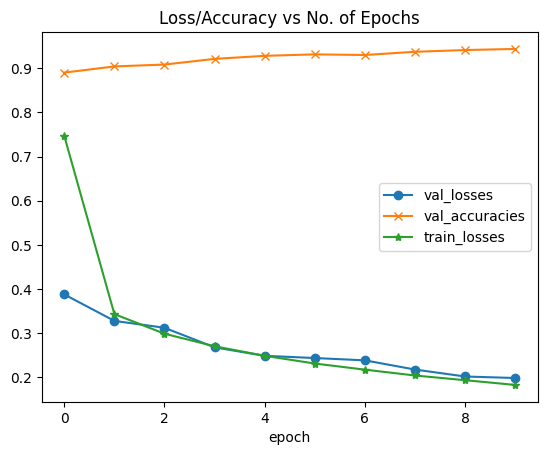

In [197]:
val_losses = [x['val_loss'] for x in val_history]
val_accuracies = [x['val_acc'] for x in val_history]
train_losses = [x for x in train_loss]

plt.plot(val_losses, '-o', label='val_losses')
plt.plot(val_accuracies, '-x', label='val_accuracies')
plt.plot(train_losses, '-*', label = 'train_losses')
plt.legend()
plt.xlabel('epoch')
plt.title('Loss/Accuracy vs No. of Epochs')